In [42]:
import pandas as pd
import os
from utils import  confidence_interval_cross_validation
import matplotlib.pyplot as plt

files  = os.listdir("task1")

f_scores = []
ics = []
labels = []
ce = []
ics_ce = []
for f in files:
    df = pd.read_csv(f"task1/{f}")
    folds = df[df["Data"] == "dev"].groupby("Fold")["f1"].idxmax()
    folds_ce = df[df["Data"] == "dev"].groupby("Fold")["ce"].idxmin()

    best_res = df.iloc[folds]["f1"]
    best_res_ce = df.iloc[folds_ce]["ce"]
    ic = confidence_interval_cross_validation(best_res)
    ic_ce = confidence_interval_cross_validation(best_res_ce)
    labels.append(f)
    ics.append(ic)
    ics_ce.append(ic_ce)
    f_scores.append(best_res.mean())
    ce.append(best_res_ce.mean())

In [59]:
import pandas as pd
import ast
from sklearn.metrics import f1_score
import numpy as np
import os

# Directorio que contiene los ficheros (cambia esta ruta si es necesario)
directory = "/home/elural/DETESTS-DIS/scripts/predictions/MultiTaskStereotype2e-5Eps95/"

# Obtener una lista de todos los archivos CSV en el directorio
files = [f for f in os.listdir(directory) if f.endswith(".csv")]

# Inicializar un diccionario para almacenar los F1-scores por fold y anotador
f1_scores_by_fold_and_annotator = {}
f1_scores_by_annotator = {f"Anotador_{i}": [] for i in range(3)}
# Recorrer cada archivo (asumiendo que cada archivo es un fold)
for file in files:
    # Extraer el número de fold del nombre del archivo (asumiendo que el fold está en el nombre del fichero)
    fold_number = int(file.split('Eps95')[1].split('.')[0])  # Esto asume un formato de archivo específico, adáptalo si es necesario
    
    # Cargar el DataFrame con las predicciones y originales
    df = pd.read_csv(os.path.join(directory, file), 
                     converters={"prediction": ast.literal_eval, "original": ast.literal_eval})
    
    # Convertir las columnas de listas en arrays de NumPy
    preds = np.array(df["prediction"].tolist())
    og = np.array(df["original"].tolist())
    
    # Inicializar un diccionario para almacenar los F1-scores de este fold

    
    # Recorrer cada anotador (asumimos que hay 3 anotadores, índice 0, 1 y 2)
    for annotator_idx in range(3):
        # Calcular el F1-score para el anotador actual
        f1 = f1_score(og[:, annotator_idx], preds[:, annotator_idx], average="binary")
        
        # Almacenar el F1-score en el diccionario, con la clave siendo el anotador
        f1_scores_by_annotator[f"Anotador_{annotator_idx}"].append(f1)
    


# Imprimir o devolver los resultados
#print(f1_scores_by_annotator)

print(np.array(f1_scores_by_annotator["Anotador_2"]).mean())
print(confidence_interval_cross_validation(f1_scores_by_annotator["Anotador_2"]))

0.7404534113243219
0.019528353633586206


In [43]:
import pandas as pd
import os
from utils import confidence_interval_cross_validation 
import ast
from sklearn.metrics import f1_score
import numpy as np

df = pd.read_csv("/home/elural/DETESTS-DIS/scripts/predictions/MultiTaskStereotype2e-5Eps95/MultiTaskStereotype2e-5Eps954.csv", converters={"prediction":ast.literal_eval, "original":ast.literal_eval})

preds = np.array(df["prediction"].tolist())
og = np.array(df["original"].tolist())
f1_score(og[:, 2], preds[:, 2], average="binary")

confidence_interval_cross_validation()


0.7540360873694207

In [6]:
import pandas as pd

test_df = pd.read_csv("/home/elural/DETESTS-DIS/scripts/test_solutions.csv")
test_df["test_case"] = "DETESTS-Dis"
test_df["stereotype"] = test_df["stereotype"].apply(lambda x: "Stereotype" if x == 1 else "NoStereotype")
test_df["stereotype_soft"] = test_df["stereotype_soft"].apply(lambda x: {"Stereotype": x, "NoStereotype": 1 - x})
test_df["implicit"] = test_df["implicit"].apply(lambda x: "Implicit" if x == 1 else "Explicit")
test_df["implicit_soft"] = test_df["implicit_soft"].apply(lambda x: {"Implicit": x, "Explicit": 1 - x})

stereo_hard_df = test_df.rename(columns={"stereotype": "value"})[["id", "test_case", "value"]].to_json("test_stereotype_hard.json", orient="records", indent=4)
stereo_soft_df = test_df.rename(columns={"stereotype_soft": "value"})[["id", "test_case", "value"]].to_json("test_stereotype_soft.json", orient="records", indent=4)
implicit_hard_df = test_df.rename(columns={"implicit": "value"})[["id", "test_case", "value"]].to_json("test_implicit_hard.json", orient="records", indent=4)
implicit_soft_df = test_df.rename(columns={"implicit_soft": "value"})[["id", "test_case", "value"]].to_json("test_implicit_soft.json", orient="records", indent=4)

In [9]:
import pandas as pd
import numpy as np
from scipy import stats

# Cargar el archivo CSV
csv_file = '/home/elural/DETESTS-DIS/scripts/logs/stereotype/annotators/MultiTaskEps0905e-5ContextAug/results_MultiTaskEps0905e-5ContextAug_hard.csv'
data = pd.read_csv(csv_file)

# Filtrar las métricas que tienen valores en NoStereotype y Stereotype
metrics = data['metric'].unique()
results = []

for metric in metrics:
    # Filtrar los datos para la métrica actual
    metric_data = data[data['metric'] == metric]
    
    # Obtener valores de NoStereotype y Stereotype
    nos = metric_data['NoStereotype'].dropna().astype(float).values
    stereotype = metric_data['Stereotype'].dropna().astype(float).values
    
    # Calcular media y intervalo de confianza para NoStereotype
    if len(nos) > 0:
        mean_nos = np.mean(nos)
        std_nos = np.std(nos, ddof=1)
        n_nos = len(nos)
        conf_interval_nos = stats.t.interval(0.95, n_nos - 1, loc=mean_nos, scale=std_nos/np.sqrt(n_nos))
        conf_interval_nos_str = f"{mean_nos:.4f} ± {conf_interval_nos[1] - mean_nos:.4f}"
    else:
        conf_interval_nos_str = "No data"
    
    # Calcular media y intervalo de confianza para Stereotype
    if len(stereotype) > 0:
        mean_stereotype = np.mean(stereotype)
        std_stereotype = np.std(stereotype, ddof=1)
        n_stereotype = len(stereotype)
        conf_interval_stereotype = stats.t.interval(0.95, n_stereotype - 1, loc=mean_stereotype, scale=std_stereotype/np.sqrt(n_stereotype))
        conf_interval_stereotype_str = f"{mean_stereotype:.4f} ± {conf_interval_stereotype[1] - mean_stereotype:.4f}"
    else:
        conf_interval_stereotype_str = "No data"
    
    results.append({
        'Metric': metric,
        'Mean_NoStereotype': conf_interval_nos_str,
        'Mean_Stereotype': conf_interval_stereotype_str
    })

# Convertir resultados a DataFrame y mostrar
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


  Metric Mean_NoStereotype Mean_Stereotype
     ICM           No data         No data
ICM-Norm           No data         No data
      F1   0.9148 ± 0.0069 0.8829 ± 0.0084
      Pr   0.9221 ± 0.0047 0.8735 ± 0.0129
      Re   0.9077 ± 0.0106 0.8925 ± 0.0063


In [4]:
import os
import pandas as pd
import numpy as np
from scipy import stats

# Función para calcular la media y el intervalo de confianza
def calculate_statistics(values):
    if len(values) > 0:
        mean = np.mean(values)
        std = np.std(values, ddof=1)
        n = len(values)
        conf_interval = stats.t.interval(0.95, n - 1, loc=mean, scale=std / np.sqrt(n))
        conf_interval_str = f"{mean:.4f} ± {conf_interval[1] - mean:.4f}"
    else:
        conf_interval_str = "No data"
    return conf_interval_str

# Función para obtener la parte del medio del nombre del archivo
def extract_run_name(filename):
    base_name = os.path.splitext(filename)[0]  # Eliminar extensión
    parts = base_name.split('_')
    if len(parts) >= 3:
        return parts[1]  # Obtener el segundo elemento (parte del medio)
    else:
        return "Unknown"  # Valor por defecto si no hay suficientes partes

# Función para procesar un archivo CSV de resultados hard
def process_hard_csv(file_path):
    print(f"Processing hard file: {file_path}")
    
    data = pd.read_csv(file_path)
    
    # Eliminar las métricas que empiezan por "ICM"
    #data = data[~data['metric'].str.startswith('ICM', na=False)]
    metrics = data['metric'].unique()
    
    results = {}
    run_name = extract_run_name(os.path.basename(file_path))

    # Inicializar un diccionario para la fila actual
    results['Run_Name'] = run_name
    
    for metric in metrics:
        metric_data = data[data['metric'] == metric]
        # Obtener valores de Explicit e Implicit
        explicit_values = metric_data['Explicit'].dropna().astype(float).values
        implicit_values = metric_data['Implicit'].dropna().astype(float).values
        average_values = metric_data['average'].dropna().astype(float).values
        # Calcular media y intervalo de confianza
        conf_interval_explicit_str = calculate_statistics(explicit_values)
        conf_interval_implicit_str = calculate_statistics(implicit_values)
        conf_interval_average_str = calculate_statistics(average_values)
        # Añadir al diccionario de resultados
        results[f'{metric}_Explicit'] = conf_interval_explicit_str
        results[f'{metric}_Implicit'] = conf_interval_implicit_str
        results[f'{metric}_Average'] = conf_interval_average_str
    return results

# Función para procesar un archivo CSV de resultados soft
def process_soft_csv(file_path):
    print(f"Processing soft file: {file_path}")
    
    data = pd.read_csv(file_path)
    
    # Filtrar para asegurarse de que solo estamos tratando con las métricas ICM-Soft, ICM-Soft-Norm y CE
    soft_metrics = ['ICM-Soft', 'ICM-Soft-Norm', 'CE']
    data = data[data['metric'].isin(soft_metrics)]
    
    results = {}
    run_name = extract_run_name(os.path.basename(file_path))

    # Inicializar un diccionario para la fila actual
    results['Run_Name'] = run_name
    
    for metric in soft_metrics:
        metric_data = data[data['metric'] == metric]
        values = metric_data['average'].dropna().astype(float).values
        
        # Calcular media y intervalo de confianza para cada métrica
        conf_interval_str = calculate_statistics(values)
        results[metric] = conf_interval_str
    
    return results

# Función principal para recorrer directorios y procesar archivos
def process_directories(root_directory):
    hard_results = {}
    soft_results = {}
    
    for subdir, _, files in os.walk(root_directory):
        for filename in files:
            if filename.startswith('result') and filename.endswith('hard.csv'):
                file_path = os.path.join(subdir, filename)
                run_name = extract_run_name(filename)
                hard_results[run_name] = process_hard_csv(file_path)
            
            elif filename.startswith('result') and filename.endswith('soft.csv'):
                file_path = os.path.join(subdir, filename)
                run_name = extract_run_name(filename)
                soft_results[run_name] = process_soft_csv(file_path)
    
    # Combinar resultados hard y soft en un solo DataFrame
    combined_results = []
    
    # Unir resultados hard y soft por 'Run_Name'
    for run_name in set(hard_results.keys()).union(soft_results.keys()):
        combined_result = {'Run_Name': run_name}
        if run_name in hard_results:
            combined_result.update(hard_results[run_name])
        if run_name in soft_results:
            combined_result.update(soft_results[run_name])
        
        combined_results.append(combined_result)
    
    # Convertir todos los resultados a un DataFrame
    results_df = pd.DataFrame(combined_results)
    
    # Ordenar el DataFrame por la columna 'Run_Name'
    results_df = results_df.sort_values(by='Run_Name')
    
    return results_df

# Directorio raíz a procesar
root_directory = '/home/elural/DETESTS-DIS/scripts/logs/implicit'  # Reemplaza con la ruta a tu directorio raíz

# Ejecutar el procesamiento y obtener el DataFrame final
results_df = process_directories(root_directory)

# Guardar los resultados en un archivo CSV
results_df.head(5)


Processing hard file: /home/elural/DETESTS-DIS/scripts/logs/implicit/soft/SoftLabelEps0905e-5ContextAug/results_SoftLabelEps0905e-5ContextAug_hard.csv
Processing soft file: /home/elural/DETESTS-DIS/scripts/logs/implicit/soft/SoftLabelEps0905e-5ContextAug/results_SoftLabelEps0905e-5ContextAug_soft.csv
Processing soft file: /home/elural/DETESTS-DIS/scripts/logs/implicit/annotators/MultiTaskEps0905e-5ContextAug/results_MultiTaskEps0905e-5ContextAug_soft.csv
Processing hard file: /home/elural/DETESTS-DIS/scripts/logs/implicit/annotators/MultiTaskEps0905e-5ContextAug/results_MultiTaskEps0905e-5ContextAug_hard.csv
Processing hard file: /home/elural/DETESTS-DIS/scripts/logs/implicit/hard/HardLabelEps0951e-5ContextAug/results_HardLabelEps0951e-5ContextAug_hard.csv
Processing soft file: /home/elural/DETESTS-DIS/scripts/logs/implicit/hard/HardLabelEps0951e-5ContextAug/results_HardLabelEps0951e-5ContextAug_soft.csv


,Run_Name,ICM_Explicit,ICM_Implicit,ICM_Average,ICM-Norm_Explicit,ICM-Norm_Implicit,ICM-Norm_Average,F1_Explicit,F1_Implicit,F1_Average,ICM-Soft,ICM-Soft-Norm,CE
2,HardLabelEps0951e-5ContextAug,No data,No data,0.0095 ± 0.0726,No data,No data,0.5049 ± 0.0533,0.9040 ± 0.0192,0.5190 ± 0.1321,0.7115 ± 0.0453,0.4277 ± 0.1586,0.5632 ± 0.0238,0.6639 ± 0.0208
0,MultiTaskEps0905e-5ContextAug,No data,No data,-0.0498 ± 0.1230,No data,No data,0.4649 ± 0.0891,0.9036 ± 0.0153,0.4388 ± 0.3095,0.6712 ± 0.1193,0.4981 ± 0.3719,0.5726 ± 0.0543,0.8567 ± 0.0902
1,SoftLabelEps0905e-5ContextAug,No data,No data,-0.0459 ± 0.0748,No data,No data,0.4644 ± 0.0568,0.9136 ± 0.0063,0.4334 ± 0.1662,0.6735 ± 0.0619,0.0870 ± 0.3862,0.5129 ± 0.0568,0.6282 ± 0.0147


In [27]:
import os
import pandas as pd
import numpy as np
from scipy import stats

# Función para calcular la media y el intervalo de confianza
def calculate_statistics(values):
    if len(values) > 0:
        mean = np.mean(values)
        std = np.std(values, ddof=1)
        n = len(values)
        conf_interval = stats.t.interval(0.95, n - 1, loc=mean, scale=std / np.sqrt(n))
        conf_interval_str = f"{mean:.4f} ± {conf_interval[1] - mean:.4f}"
    else:
        conf_interval_str = "No data"
    return conf_interval_str

# Función para obtener la parte del medio del nombre del archivo
def extract_middle_part(filename):
    base_name = os.path.splitext(filename)[0]  # Eliminar extensión
    parts = base_name.split('_')
    if len(parts) >= 3:
        return parts[1]  # Obtener el segundo elemento (parte del medio)
    else:
        return "Unknown"  # Valor por defecto si no hay suficientes partes

# Función para procesar un archivo CSV
def process_csv(file_path):
    print(f"Processing file: {file_path}")
    
    data = pd.read_csv(file_path)
    
    # Eliminar las métricas que empiezan por "ICM"
    #data = data[~data['metric'].str.startswith('ICM', na=False)]
    
    metrics = data['metric'].unique()
    results = []
    
    # Obtener la parte del medio del nombre del archivo
    run_name = extract_middle_part(os.path.basename(file_path))

    # Inicializar un diccionario para la fila actual
    row = {'Run_Name': run_name}
    
    for metric in metrics:
        metric_data = data[data['metric'] == metric]

        # Obtener valores de NoStereotype y Stereotype
        nos = metric_data['NoStereotype'].dropna().astype(float).values
        stereotype = metric_data['Stereotype'].dropna().astype(float).values
        
        # Calcular media y intervalo de confianza
        conf_interval_nos_str = calculate_statistics(nos)
        conf_interval_stereotype_str = calculate_statistics(stereotype)
        
        # Añadir al diccionario de resultados
        row[f'{metric}_NoStereotype'] = conf_interval_nos_str
        row[f'{metric}_Stereotype'] = conf_interval_stereotype_str
    
    results.append(row)
    return results

# Función principal para recorrer directorios y procesar archivos
def process_directories(root_directory):
    all_results = []
    
    for subdir, _, files in os.walk(root_directory):
        for filename in files:
            if filename.startswith('result') and filename.endswith('hard.csv'):
                file_path = os.path.join(subdir, filename)
                file_results = process_csv(file_path)
                all_results.extend(file_results)
    
    # Convertir todos los resultados a un DataFrame
    results_df = pd.DataFrame(all_results)
    
    # Ordenar el DataFrame por la columna 'Run_Name'
    results_df = results_df.sort_values(by='Run_Name')
    
    return results_df

# Directorio raíz a procesar
root_directory = '/home/elural/DETESTS-DIS/scripts/logs/stereotype/'  # Reemplaza con la ruta a tu directorio raíz

# Ejecutar el procesamiento y obtener el DataFrame final
results_df = process_directories(root_directory)
results_df.to_csv('logs/stereotype_hard_results.csv', index=False)  # Guardar los resultados en un archivo CSV


Processing file: /home/elural/DETESTS-DIS/scripts/logs/stereotype/soft/SoftLabel5e-5/results_SoftLabel5e-5_hard.csv
Processing file: /home/elural/DETESTS-DIS/scripts/logs/stereotype/soft/SoftLabelEps0975e-5/results_SoftLabelEps0975e-5_hard.csv
Processing file: /home/elural/DETESTS-DIS/scripts/logs/stereotype/soft/SoftLabelEps0905e-5/results_SoftLabelEps0905e-5_hard.csv
Processing file: /home/elural/DETESTS-DIS/scripts/logs/stereotype/soft/SoftLabelEps0952e-5/results_SoftLabelEps0952e-5_hard.csv
Processing file: /home/elural/DETESTS-DIS/scripts/logs/stereotype/soft/SoftLabelEps0951e-5/results_SoftLabelEps0951e-5_hard.csv
Processing file: /home/elural/DETESTS-DIS/scripts/logs/stereotype/soft/SoftLabelEps0951e-4/results_SoftLabelEps0951e-4_hard.csv
Processing file: /home/elural/DETESTS-DIS/scripts/logs/stereotype/soft/SoftLabelEps0905e-5Context/results_SoftLabelEps0905e-5Context_hard.csv
Processing file: /home/elural/DETESTS-DIS/scripts/logs/stereotype/soft/SoftLabelEps0971e-4/results_Sof

In [29]:
import os
import pandas as pd
import numpy as np
from scipy import stats

# Función para calcular la media y el intervalo de confianza
def calculate_statistics(values):
    if len(values) > 0:
        mean = np.mean(values)
        std = np.std(values, ddof=1)
        n = len(values)
        conf_interval = stats.t.interval(0.95, n - 1, loc=mean, scale=std / np.sqrt(n))
        conf_interval_str = f"{mean:.4f} ± {conf_interval[1] - mean:.4f}"
    else:
        conf_interval_str = "No data"
    return conf_interval_str

# Función para obtener la parte del medio del nombre del archivo
def extract_run_name(filename):
    base_name = os.path.splitext(filename)[0]  # Eliminar extensión
    parts = base_name.split('_')
    if len(parts) >= 3:
        return parts[1]  # Obtener el segundo elemento (parte del medio)
    else:
        return "Unknown"  # Valor por defecto si no hay suficientes partes

# Función para procesar un archivo CSV de resultados hard
def process_hard_csv(file_path):
    print(f"Processing hard file: {file_path}")
    
    data = pd.read_csv(file_path)
    
    # Eliminar las métricas que empiezan por "ICM"
    data = data[~data['metric'].str.startswith('ICM', na=False)]
    metrics = data['metric'].unique()
    
    results = {}
    run_name = extract_run_name(os.path.basename(file_path))

    # Inicializar un diccionario para la fila actual
    results['Run_Name'] = run_name
    
    for metric in metrics:
        metric_data = data[data['metric'] == metric]
        # Obtener valores de NoStereotype y Stereotype
        nos = metric_data['NoStereotype'].dropna().astype(float).values
        stereotype = metric_data['Stereotype'].dropna().astype(float).values
        
        # Calcular media y intervalo de confianza
        conf_interval_nos_str = calculate_statistics(nos)
        conf_interval_stereotype_str = calculate_statistics(stereotype)
        
        # Añadir al diccionario de resultados
        results[f'{metric}_NoStereotype'] = conf_interval_nos_str
        results[f'{metric}_Stereotype'] = conf_interval_stereotype_str
    
    return results

# Función para procesar un archivo CSV de resultados soft
def process_soft_csv(file_path):
    print(f"Processing soft file: {file_path}")
    
    data = pd.read_csv(file_path)
    
    # Asegurarse de que solo estamos tratando con la métrica 'CE'
    data = data[data['metric'] == 'CE']
    ce_values = data['average'].dropna().astype(float).values
    
    results = {}
    run_name = extract_run_name(os.path.basename(file_path))

    # Inicializar un diccionario para la fila actual
    results['Run_Name'] = run_name
    
    # Calcular media y intervalo de confianza para CE
    conf_interval_ce_str = calculate_statistics(ce_values)
    results['CE'] = conf_interval_ce_str
    
    return results

# Función principal para recorrer directorios y procesar archivos
def process_directories(root_directory):
    hard_results = {}
    soft_results = {}
    
    for subdir, _, files in os.walk(root_directory):
        for filename in files:
            if filename.startswith('result') and filename.endswith('hard.csv'):
                file_path = os.path.join(subdir, filename)
                run_name = extract_run_name(filename)
                hard_results[run_name] = process_hard_csv(file_path)
            
            elif filename.startswith('result') and filename.endswith('soft.csv'):
                file_path = os.path.join(subdir, filename)
                run_name = extract_run_name(filename)
                soft_results[run_name] = process_soft_csv(file_path)
    
    # Combinar resultados hard y soft en un solo DataFrame
    combined_results = []
    
    # Unir resultados hard y soft por 'Run_Name'
    for run_name in set(hard_results.keys()).union(soft_results.keys()):
        combined_result = {'Run_Name': run_name}
        if run_name in hard_results:
            combined_result.update(hard_results[run_name])
        if run_name in soft_results:
            combined_result.update(soft_results[run_name])
        
        combined_results.append(combined_result)
    
    # Convertir todos los resultados a un DataFrame
    results_df = pd.DataFrame(combined_results)
    
    # Ordenar el DataFrame por la columna 'Run_Name'
    results_df = results_df.sort_values(by='Run_Name')
    
    return results_df

# Directorio raíz a procesar
root_directory = '/home/elural/DETESTS-DIS/scripts/logs/stereotype'  # Reemplaza con la ruta a tu directorio raíz

# Ejecutar el procesamiento y obtener el DataFrame final
results_df = process_directories(root_directory)
results_


Processing soft file: /home/elural/DETESTS-DIS/scripts/logs/stereotype/soft/SoftLabel5e-5/results_SoftLabel5e-5_soft.csv
Processing hard file: /home/elural/DETESTS-DIS/scripts/logs/stereotype/soft/SoftLabel5e-5/results_SoftLabel5e-5_hard.csv
Processing soft file: /home/elural/DETESTS-DIS/scripts/logs/stereotype/soft/SoftLabelEps0975e-5/results_SoftLabelEps0975e-5_soft.csv
Processing hard file: /home/elural/DETESTS-DIS/scripts/logs/stereotype/soft/SoftLabelEps0975e-5/results_SoftLabelEps0975e-5_hard.csv
Processing hard file: /home/elural/DETESTS-DIS/scripts/logs/stereotype/soft/SoftLabelEps0905e-5/results_SoftLabelEps0905e-5_hard.csv
Processing soft file: /home/elural/DETESTS-DIS/scripts/logs/stereotype/soft/SoftLabelEps0905e-5/results_SoftLabelEps0905e-5_soft.csv
Processing soft file: /home/elural/DETESTS-DIS/scripts/logs/stereotype/soft/SoftLabelEps0952e-5/results_SoftLabelEps0952e-5_soft.csv
Processing hard file: /home/elural/DETESTS-DIS/scripts/logs/stereotype/soft/SoftLabelEps0952e

In [31]:
import pandas as pd

def obtener_mejores_resultados_por_fold(archivo_csv):
    # Leer el archivo CSV
    df = pd.read_csv(archivo_csv)
    
    # Encontrar el índice de la fila con el menor dev_loss para cada fold
    idx_min_dev_loss = df.groupby('Fold')['dev_loss'].idxmin()
    
    # Obtener las filas con el menor dev_loss para cada fold
    mejores_resultados = df.loc[idx_min_dev_loss]
    
    return mejores_resultados

# Ejemplo de uso
archivo_csv = '/home/eliasurios/Documentos/DETESTS-DIS/scripts/task1/HardLabelStereotype1e-5Eps97ContextAug.csv'
mejores_resultados = obtener_mejores_resultados_por_fold(archivo_csv)
print(mejores_resultados['f1_1'].mean())


Processing hard file: /home/elural/DETESTS-DIS/scripts/logs/stereotype/annotators/MultiTask5e-5/results_MultiTask5e-5_hard.csv
Processing soft file: /home/elural/DETESTS-DIS/scripts/logs/stereotype/annotators/MultiTask5e-5/results_MultiTask5e-5_soft.csv
Processing soft file: /home/elural/DETESTS-DIS/scripts/logs/stereotype/annotators/MultiTaskEps0951e-4/results_MultiTaskEps0951e-4_soft.csv
Processing hard file: /home/elural/DETESTS-DIS/scripts/logs/stereotype/annotators/MultiTaskEps0951e-4/results_MultiTaskEps0951e-4_hard.csv
Processing hard file: /home/elural/DETESTS-DIS/scripts/logs/stereotype/annotators/MultiTaskEps0905e-5Aug/results_MultiTaskEps0905e-5Aug_hard.csv
Processing soft file: /home/elural/DETESTS-DIS/scripts/logs/stereotype/annotators/MultiTaskEps0905e-5Aug/results_MultiTaskEps0905e-5Aug_soft.csv
Processing soft file: /home/elural/DETESTS-DIS/scripts/logs/stereotype/annotators/MultiTaskEps0905e-5ContextAug/results_MultiTaskEps0905e-5ContextAug_soft.csv
Processing hard fil

IndexError: tuple index out of range

In [23]:
import pandas as pd
from scipy import stats

def obtener_metricas_con_intervalo_confianza(lista_archivos_csv):
    lista_mejores_resultados = []
    lista_promedios = []

    for archivo_csv in lista_archivos_csv:
        df = pd.read_csv(archivo_csv)
        
        # Encontrar el índice de la fila con el menor dev_loss para cada fold
        idx_min_dev_loss = df.groupby('Fold')['dev_loss'].idxmin()
        
        # Obtener las filas con el menor dev_loss para cada fold y seleccionar las métricas deseadas
        mejores_resultados = df.loc[idx_min_dev_loss, ['f1_1', 'precision_1', 'recall_1']]
        lista_mejores_resultados.append(mejores_resultados)
        
        # Calcular promedios y sus intervalos de confianza
        promedios = df[['f1_1', 'precision_1', 'recall_1']].mean()
        std_error = df[['f1_1', 'precision_1', 'recall_1']].sem()
        intervalo_confianza = stats.t.interval(0.95, len(df) - 1, loc=promedios, scale=std_error)
        
        promedios_con_intervalo = {
            'f1_1': promedios['f1_1'],
            'precision_1': promedios['precision_1'],
            'recall_1': promedios['recall_1'],
            'metrica_ic': intervalo_confianza
        }
        
        lista_promedios.append(promedios_con_intervalo)

    # Concatenar todos los DataFrames de mejores resultados
    resultados_consolidados = pd.concat(lista_mejores_resultados, ignore_index=True)
    
    # Crear un DataFrame para los promedios con intervalos de confianza
    df_promedios = pd.DataFrame(lista_promedios)
    
    return resultados_consolidados, df_promedios




# Ejemplo de uso
lista_archivos_csv = ['/home/eliasurios/Documentos/DETESTS-DIS/scripts/task1/HardLabelStereotypeLr1e-5Eps97.csv', '/home/eliasurios/Documentos/DETESTS-DIS/scripts/task1/HardLabelStereotype1e-5Eps97Context.csv', '/home/eliasurios/Documentos/DETESTS-DIS/scripts/task1/HardLabelStereotype1e-5Eps97ContextAug.csv']
mejores_metricas, promedios_con_intervalos = obtener_metricas_con_intervalo_confianza(lista_archivos_csv)

print("Mejores Resultados:")
print(mejores_metricas)
print("\nPromedios con Intervalos de Confianza:")
print(promedios_con_intervalos)

Mejores Resultados:
        f1_1  precision_1  recall_1
0   0.757895     0.755725  0.760077
1   0.755471     0.749057  0.761996
2   0.714588     0.795294  0.648752
3   0.716387     0.791183  0.654511
4   0.752964     0.775967  0.731286
5   0.768650     0.756506  0.781190
6   0.751020     0.801743  0.706334
7   0.726368     0.754132  0.700576
8   0.734440     0.799097  0.679463
9   0.756757     0.790795  0.725528
10  0.861261     0.811545  0.917466
11  0.867281     0.834220  0.903071
12  0.855936     0.837466  0.875240
13  0.841351     0.901316  0.788868
14  0.858434     0.900000  0.820537

Promedios con Intervalos de Confianza:
       f1_1  precision_1  recall_1  \
0  0.767892     0.803300  0.744242   
1  0.774488     0.807042  0.754223   
2  0.874221     0.879454  0.872241   

                                          metrica_ic  
0  ([0.7265925075281365, 0.7698608974420955, 0.69...  
1  ([0.7313963825632908, 0.7724132319098255, 0.70...  
2  ([0.8482441142428974, 0.8557609331159063, 0

In [78]:
import pandas as pd
import numpy as np
from scipy import stats

def calcular_h(datos, intervalo_confianza=95):
    """
    Calcula el intervalo de confianza para un conjunto de datos.
    
    :param datos: Lista o array de datos.
    :param intervalo_confianza: Nivel de intervalo de confianza en porcentaje.
    :return: Valor del margen de error.
    """
    datos = np.array(datos)
    media = np.mean(datos)
    desviacion_estandar = np.std(datos, ddof=1)
    n = len(datos)
    error_margin = stats.t.ppf((1 + intervalo_confianza / 100) / 2., n - 1) * (desviacion_estandar / np.sqrt(n))
    return error_margin

def obtener_metricas_con_intervalo_confianza(lista_archivos_csv):
    lista_mejores_resultados = []
    lista_promedios = []

    for archivo_csv in lista_archivos_csv:
        df = pd.read_csv(archivo_csv)
        
        # Encontrar el índice de la fila con el f1_1 máximo para cada fold
        idx_max_f1_1 = df.groupby('Fold')['f1_1'].idxmax()
        
        # Obtener las filas con el f1_1 máximo para cada fold y seleccionar las métricas deseadas
        mejores_resultados = df.loc[idx_max_f1_1, ['f1_1', 'precision_1', 'recall_1']]
        lista_mejores_resultados.append(mejores_resultados)
        
        # Calcular promedios y sus márgenes de error
        f1_h = calcular_h(df['f1_1'])
        precision_h = calcular_h(df['precision_1'])
        recall_h = calcular_h(df['recall_1'])
        
        promedios_con_h = {
            'f1_1': df['f1_1'].mean(),
            'precision_1': df['precision_1'].mean(),
            'recall_1': df['recall_1'].mean(),
            'f1_h': f1_h,
            'precision_h': precision_h,
            'recall_h': recall_h
        }
        
        lista_promedios.append(promedios_con_h)

    # Concatenar todos los DataFrames de mejores resultados
    resultados_consolidados = pd.concat(lista_mejores_resultados, ignore_index=True)
    
    # Crear un DataFrame para los promedios con márgenes de error
    df_promedios = pd.DataFrame(lista_promedios)
    
    return resultados_consolidados, df_promedios

all_metrics_means = []
hard_labels = ['/home/eliasurios/Documentos/DETESTS-DIS/scripts/task1/HardLabelStereotypeLr1e-5Eps97.csv', '/home/eliasurios/Documentos/DETESTS-DIS/scripts/task1/HardLabelStereotype1e-5Eps97Context.csv', '/home/eliasurios/Documentos/DETESTS-DIS/scripts/task1/HardLabelStereotype1e-5Eps97ContextAug.csv']
hard_labels_metrics, hard_labels_metrics_with_ic = obtener_metricas_con_intervalo_confianza(hard_labels)
soft_labels = ['/home/eliasurios/Documentos/DETESTS-DIS/scripts/task1/SoftLabelStereotype2e-5Eps90.csv', '/home/eliasurios/Documentos/DETESTS-DIS/scripts/task1/SoftLabelStereotype2e-5Eps90Context.csv', '/home/eliasurios/Documentos/DETESTS-DIS/scripts/task1/SoftLabelStereotype2e-5Eps90ContextAug.csv']
soft_labels_metrics, soft_labels_metrics_with_ic = obtener_metricas_con_intervalo_confianza(soft_labels)
multi_task_labels = ['/home/eliasurios/Documentos/DETESTS-DIS/scripts/task1/MultiTaskStereotype2e-5Eps95.csv', '/home/eliasurios/Documentos/DETESTS-DIS/scripts/task1/MultiTaskStereotype2e-5Eps95Context.csv', '/home/eliasurios/Documentos/DETESTS-DIS/scripts/task1/MultiTaskStereotype2e-5Eps95ContextAug.csv']
multi_task_metrics, multi_task_metrics_with_ic = obtener_metricas_con_intervalo_confianza(multi_task_labels)

all_metrics_means = hard_labels_metrics_with_ic["f1_1"].values.tolist() +  soft_labels_metrics_with_ic["f1_1"].values.tolist() +   multi_task_metrics_with_ic["f1_1"].values.tolist()
all_metrics_means


[0.7678918293468335,
 0.7744875325802635,
 0.8742212934439618,
 0.7894563943828409,
 0.7955196642662868,
 0.891979905104807,
 0.777598890252266,
 0.7791939540496249,
 0.8841600269505332]

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

gold_file = "train.csv"
multi_hard_file = "/home/elural/DETESTS-DIS/scripts/logs/stereotype/annotators/MultiTaskEps0905e-5/Fold_5/MultiTaskEps0905e-5_fold5_hard.json"
multi_soft_file = "/home/elural/DETESTS-DIS/scripts/logs/stereotype/soft/SoftLabelEps0905e-5/Fold_5/SoftLabelEps0905e-5_fold5_soft.json"

gold_df = pd.read_csv(gold_file)
multi_hard_df = pd.read_json(multi_hard_file, orient='records')
multi_soft_df = pd.read_json(multi_soft_file, orient='records')

multi_soft_df["hard"] = multi_soft_df["value"].apply(lambda x: 1 if x['Stereotype'] > x['NoStereotype'] else 0)
multi_soft_df["soft"] = multi_soft_df["value"].apply(lambda x: x["Stereotype"])
gold_df_filtered = gold_df[gold_df["id"].isin(multi_hard_df["id"])]

df_combined = pd.merge(multi_soft_df, gold_df, on="id")

falsos_positivos = df_combined[(df_combined["stereotype"] == 0) & (df_combined["hard"] == 1)]

falsos_negativos = df_combined[(df_combined["stereotype"] == 1) & (df_combined["hard"] == 0)]

errores = pd.concat([falsos_positivos, falsos_negativos], ignore_index=True)

,id,value,test_case,hard,soft,source,comment_id,text,level1,level2,...,stereotype_a1,stereotype_a2,stereotype_a3,stereotype,stereotype_soft,implicit_a1,implicit_a2,implicit_a3,implicit,implicit_soft
0,d_11_04,"{'NoStereotype': 0.21221263710000002, 'Stereot...",DETESTS-Dis,1,0.787787,detests,d_11,Todos ellos son igual de peligrosos y pernicis...,d_11_03,0,...,0,0,0,0,0.0474,0,0,0,0,0.0474
1,d_24_03,"{'NoStereotype': 0.426554352, 'Stereotype': 0....",DETESTS-Dis,1,0.573446,detests,d_24,Es que manda güevos que sea de conocimiento pú...,d_24_02,0,...,0,0,0,0,0.0474,0,0,0,0,0.0474
2,d_45_03,"{'NoStereotype': 0.1764643192, 'Stereotype': 0...",DETESTS-Dis,1,0.823536,detests,d_45,"Habra que analizar como se radicalizaron, quie...",d_45_02,d_41,...,0,1,0,0,0.2689,0,1,0,0,0.2689
3,d_59_01,"{'NoStereotype': 0.3586485088, 'Stereotype': 0...",DETESTS-Dis,1,0.641351,detests,d_59,Obviamente es una exageracion para explicar co...,0,0,...,0,0,0,0,0.0474,0,0,0,0,0.0474
4,d_94_02,"{'NoStereotype': 0.46603348850000004, 'Stereot...",DETESTS-Dis,1,0.533966,detests,d_94,"Es por ello que nuestro sistema legal, por eje...",d_94_01,0,...,1,0,0,0,0.2689,0,0,0,0,0.0474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,s_3804,"{'NoStereotype': 0.5482159853, 'Stereotype': 0...",DETESTS-Dis,0,0.451784,stereohoax,s_3804,He dicho crimen importado. Y si cuando alguien...,0,s_3798,...,0,1,1,1,0.7311,0,1,0,0,0.2689
249,s_3837,"{'NoStereotype': 0.7798108459, 'Stereotype': 0...",DETESTS-Dis,0,0.220189,stereohoax,s_3837,Otro extranjero? NO PODÍA SABERSE!,0,s_3831,...,0,1,1,1,0.7311,0,1,0,0,0.2689
250,s_3851,"{'NoStereotype': 0.5060854554, 'Stereotype': 0...",DETESTS-Dis,0,0.493915,stereohoax,s_3851,"Las víctimas extranjeras ocupan el 43,2% del t...",0,0,...,1,1,1,1,0.9526,1,1,0,1,0.7311
251,s_3895,"{'NoStereotype': 0.9264800549000001, 'Stereoty...",DETESTS-Dis,0,0.073520,stereohoax,s_3895,"Pero si es verdad, es xenófobo decir la verdad?",0,s_3894,...,0,1,1,1,0.7311,0,1,0,0,0.2689


          soft  stereotype_soft
0     0.046826           0.0474
1     0.043635           0.0474
2     0.042610           0.0474
3     0.058137           0.0474
4     0.278862           0.0474
...        ...              ...
2497  0.938994           0.9526
2498  0.934336           0.9526
2499  0.947495           0.9526
2500  0.934561           0.9526
2501  0.960507           0.9526

[2502 rows x 2 columns]


/tmp/ipykernel_1760435/4230425754.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Tipo', y='Probabilidad', data=df_visualizacion,


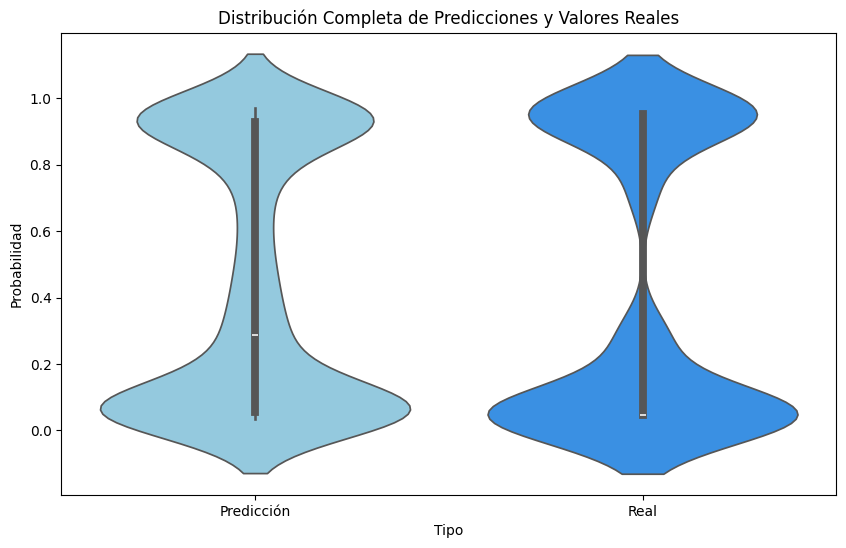

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def crear_violin_plot_completo(gold_file, multi_soft_file):
    # Cargar los archivos
    gold_df = pd.read_csv(gold_file)
    soft_df = pd.read_json(multi_soft_file, orient='records')

    # Calcular las etiquetas hard y soft
    soft_df["soft"] = soft_df["value"].apply(lambda x: x["Stereotype"])
    # Combinar ambos DataFrames
    df_combined = pd.merge(soft_df, gold_df, on="id")
    print(df_combined[["soft", "stereotype_soft"]])
    # Preparar el DataFrame para visualización
    df_visualizacion = pd.DataFrame({
        'Tipo': ['Predicción'] * len(df_combined) + ['Real'] * len(df_combined),
        'Probabilidad': pd.concat([df_combined['soft'], df_combined['stereotype_soft']])
    })

    # Crear el violin plot con diferentes colores
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Tipo', y='Probabilidad', data=df_visualizacion,
                   palette={'Predicción': 'skyblue', 'Real': 'dodgerblue'})
    plt.title('Distribución Completa de Predicciones y Valores Reales')
    plt.show()

crear_violin_plot_completo("train_augmented.csv", "/home/elural/DETESTS-DIS/scripts/logs/stereotype/soft/SoftLabelEps0905e-5ContextAug/Fold_5/SoftLabelEps0905e-5ContextAug_fold5_soft.json")

In [2]:
import os

def filtrar_ficheros_ckpt(directorio):
    # Lista para almacenar los archivos .ckpt encontrados
    ficheros_ckpt = []

    # Recorrer todos los directorios y subdirectorios
    for raiz, subdirs, archivos in os.walk(directorio):
        # Filtrar los archivos que terminan en .ckpt
        for fichero in archivos:
            if fichero.endswith('.ckpt'):
                # Agregar el camino completo del archivo a la lista
                ficheros_ckpt.append(os.path.join(raiz, fichero))

    return ficheros_ckpt

# Ejemplo de uso:
directorio = '/home/elural/DETESTS-DIS/scripts/logs/stereotype/hard/HardLabelEps0951e-5ContextAug'  # Reemplaza con la ruta al directorio que quieres inspeccionar

ficheros = filtrar_ficheros_ckpt(directorio)

# Imprimir los archivos .ckpt encontrados
for fichero in sorted(ficheros):
    print(fichero)


/home/elural/DETESTS-DIS/scripts/logs/stereotype/hard/HardLabelEps0951e-5ContextAug/Fold_1/epoch=2-step=939.ckpt
/home/elural/DETESTS-DIS/scripts/logs/stereotype/hard/HardLabelEps0951e-5ContextAug/Fold_2/epoch=2-step=939.ckpt
/home/elural/DETESTS-DIS/scripts/logs/stereotype/hard/HardLabelEps0951e-5ContextAug/Fold_3/epoch=1-step=626.ckpt
/home/elural/DETESTS-DIS/scripts/logs/stereotype/hard/HardLabelEps0951e-5ContextAug/Fold_4/epoch=2-step=939.ckpt
/home/elural/DETESTS-DIS/scripts/logs/stereotype/hard/HardLabelEps0951e-5ContextAug/Fold_5/epoch=3-step=1252.ckpt


/home/elural/DETESTS-DIS/scripts/logs/stereotype/soft/SoftLabelEps0905e-5/Fold_5/SoftLabelEps0905e-5_fold5_soft.json
['d_0_03' 'd_0_04' 'd_0_06' ... 's_4269' 's_4270' 's_4276']


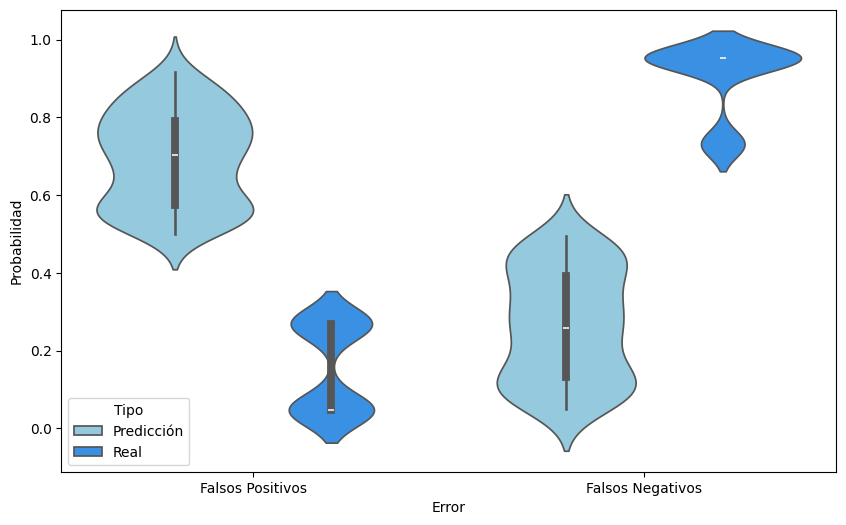

/home/elural/DETESTS-DIS/scripts/logs/stereotype/hard/HardLabelEps0951e-5/Fold_5/HardLabelEps0951e-5_fold5_soft.json
['d_0_07' 'd_2_01' 'd_2_03' ... 's_4267' 's_4274' 's_4275']


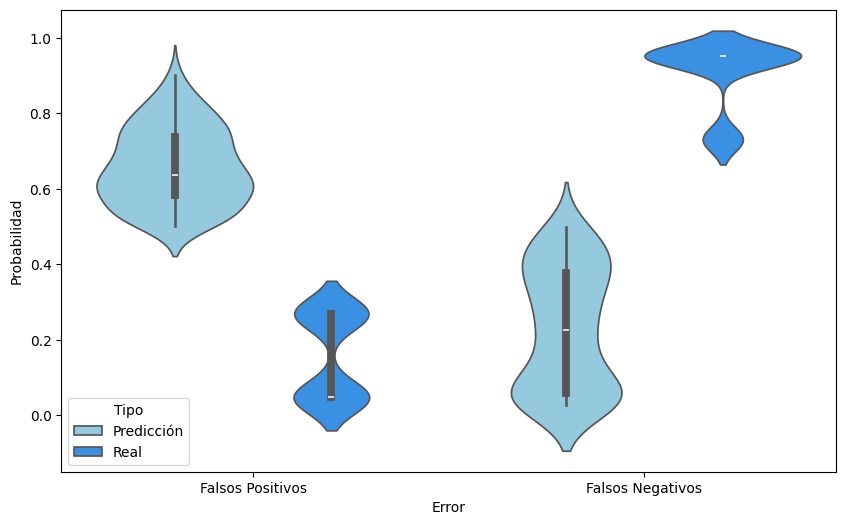

/home/elural/DETESTS-DIS/scripts/logs/stereotype/annotators/MultiTaskEps0905e-5ContextAug/Fold_5/MultiTaskEps0905e-5ContextAug_fold5_soft.json
['d_0_03' 'd_0_04' 'd_0_06' ... 's_4269_a' 's_4270_a' 's_4276_a']


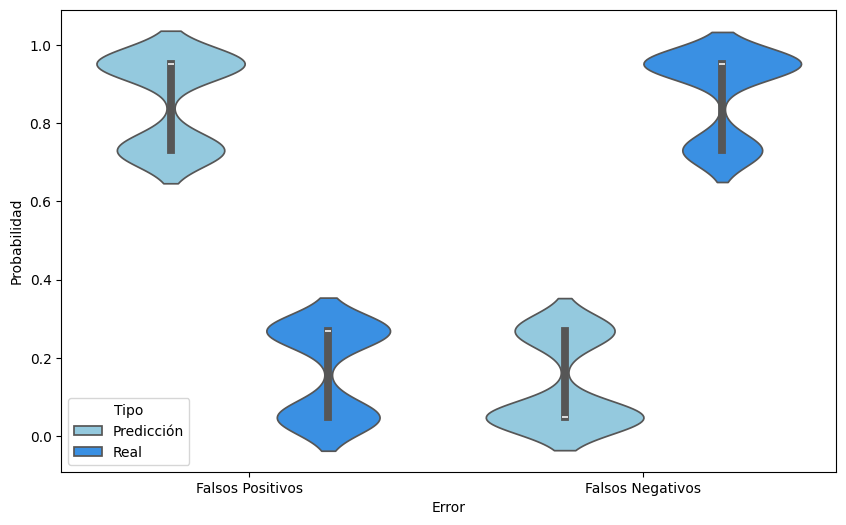

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def crear_violin_plot(gold_file, multi_soft_file):
    # Cargar los archivos
    gold_df = pd.read_csv(gold_file)
    soft_df = pd.read_json(multi_soft_file, orient='records')

    # Calcular las etiquetas hard y soft
    soft_df["hard"] = soft_df["value"].apply(lambda x: 1 if x['Stereotype'] > x['NoStereotype'] else 0)
    soft_df["soft"] = soft_df["value"].apply(lambda x: x["Stereotype"])


    # Combinar ambos DataFrames
    df_combined = pd.merge(soft_df, gold_df, on="id")
    print(df_combined["id"].unique())
    # Identificar Falsos Positivos (FP) y Falsos Negativos (FN)
    falsos_positivos = df_combined[(df_combined["stereotype"] == 0) & (df_combined["hard"] == 1)]
    falsos_negativos = df_combined[(df_combined["stereotype"] == 1) & (df_combined["hard"] == 0)]
    # Preparar el DataFrame para visualización
    df_fp = pd.DataFrame({
        'Error': ['Falsos Positivos'] * len(falsos_positivos) * 2,
        'Tipo': ['Predicción'] * len(falsos_positivos) + ['Real'] * len(falsos_positivos),
        'Probabilidad': pd.concat([falsos_positivos['soft'], falsos_positivos['stereotype_soft']])
    })

    df_fn = pd.DataFrame({
        'Error': ['Falsos Negativos'] * len(falsos_negativos) * 2,
        'Tipo': ['Predicción'] * len(falsos_negativos) + ['Real'] * len(falsos_negativos),
        'Probabilidad': pd.concat([falsos_negativos['soft'], falsos_negativos['stereotype_soft']])
    })

    df_visualizacion = pd.concat([df_fp, df_fn])

    # Crear el violin plot con diferentes colores
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Error', y='Probabilidad', hue='Tipo', data=df_visualizacion,
                   palette={'Predicción': 'skyblue', 'Real': 'dodgerblue'}, split=False)
    #plt.title('Distribución de Probabilidades para Falsos Positivos y Falsos Negativos')
    plt.plot()
    plt.show()

# Uso de la función
crear_violin_plot("train.csv", "/home/elural/DETESTS-DIS/scripts/logs/stereotype/soft/SoftLabelEps0905e-5/Fold_5/SoftLabelEps0905e-5_fold5_soft.json")
crear_violin_plot("train.csv", "/home/elural/DETESTS-DIS/scripts/logs/stereotype/hard/HardLabelEps0951e-5/Fold_5/HardLabelEps0951e-5_fold5_soft.json")
crear_violin_plot("train_augmented.csv", "/home/elural/DETESTS-DIS/scripts/logs/stereotype/annotators/MultiTaskEps0905e-5ContextAug/Fold_5/MultiTaskEps0905e-5ContextAug_fold5_soft.json")

/tmp/ipykernel_1760435/3041899674.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Tipo', y='Probabilidad', data=df_visualizacion, palette={'FP (predicción)': 'skyblue', 'FP (real)': 'skyblue',


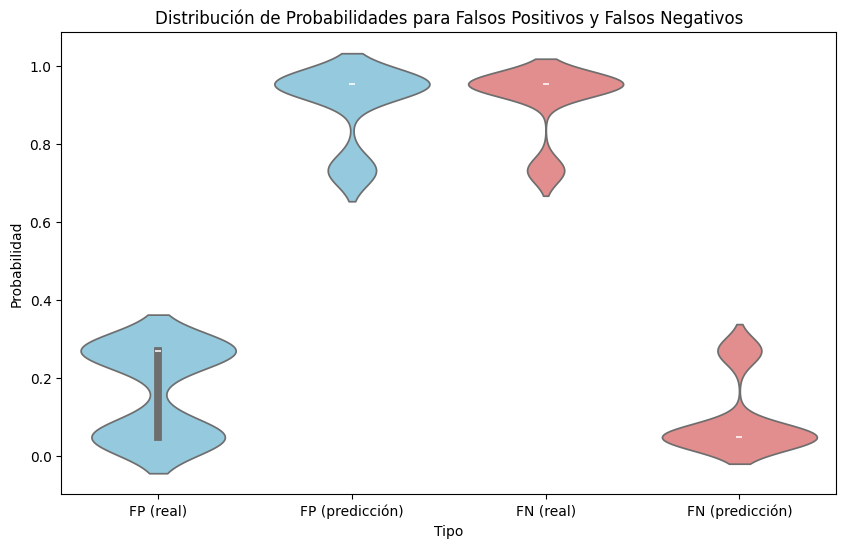

In [39]:
df_fp = pd.DataFrame({
    'Tipo': ['FP (real)', 'FP (predicción)'],
    'Probabilidad': [falsos_positivos['stereotype_soft'], falsos_positivos['soft']]
}).explode('Probabilidad')

df_fn = pd.DataFrame({
    'Tipo': ['FN (real)', 'FN (predicción)' ],
    'Probabilidad': [falsos_negativos['stereotype_soft'], falsos_negativos['soft']]
}).explode('Probabilidad')

df_visualizacion = pd.concat([df_fp, df_fn])

# Crear el violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Tipo', y='Probabilidad', data=df_visualizacion, palette={'FP (predicción)': 'skyblue', 'FP (real)': 'skyblue',
                        'FN (predicción)': 'lightcoral', 'FN (real)': 'lightcoral'})
plt.title('Distribución de Probabilidades para Falsos Positivos y Falsos Negativos')
plt.show()

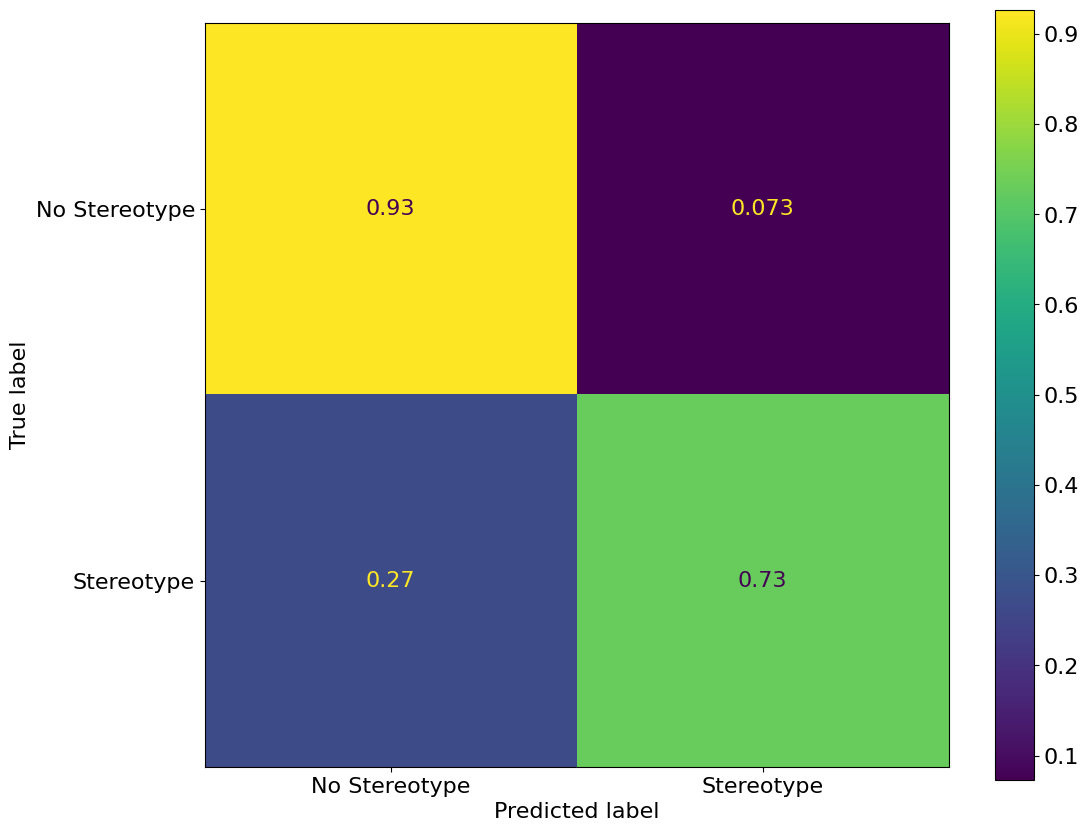

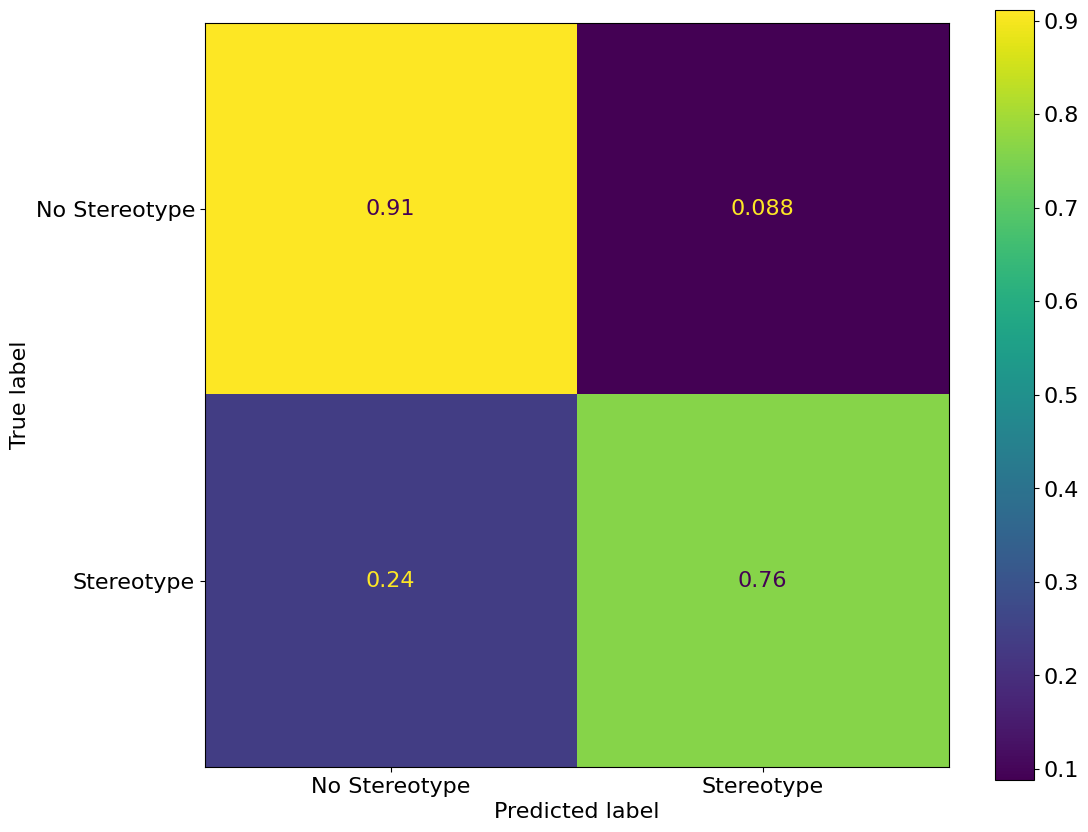

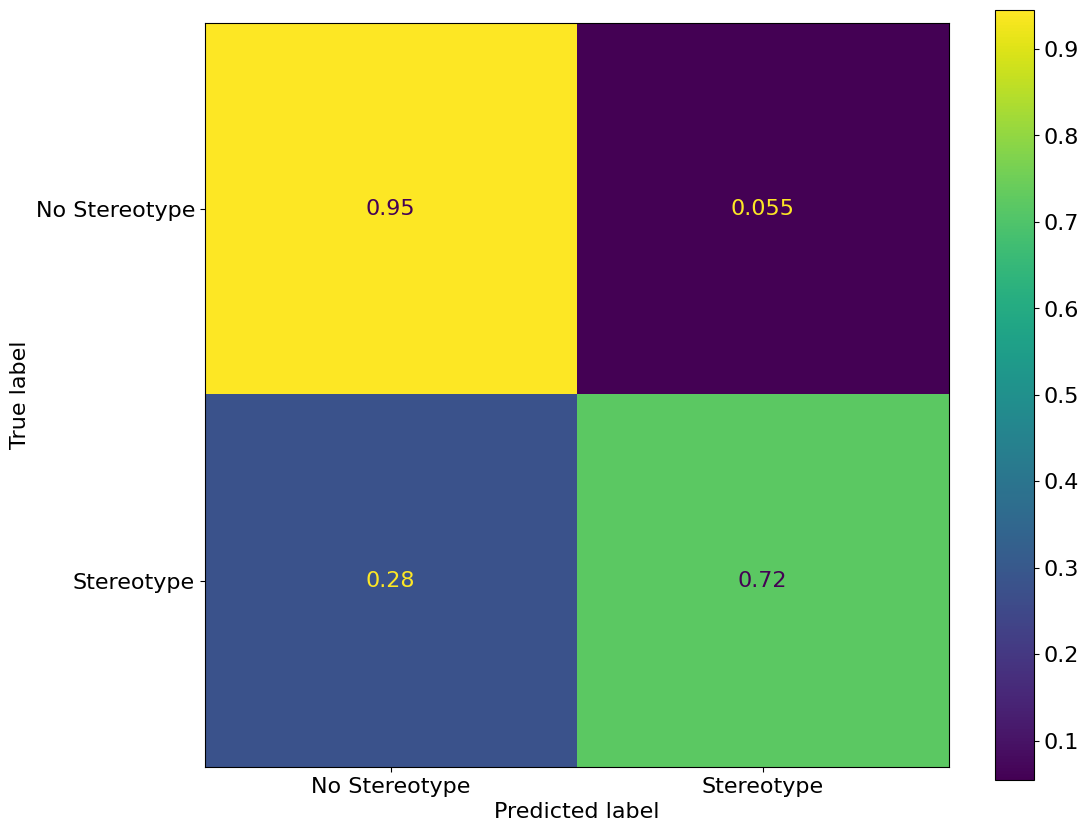

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = 12, 10
gold_file = "train.csv"
hard_file = "/home/elural/DETESTS-DIS/scripts/logs/stereotype/hard/HardLabelEps0951e-5/Fold_5/HardLabelEps0951e-5_fold5_hard.json"
soft_file = "/home/elural/DETESTS-DIS/scripts/logs/stereotype/soft/SoftLabelEps0905e-5/Fold_5/SoftLabelEps0905e-5_fold5_hard.json"
ann_file = "/home/elural/DETESTS-DIS/scripts/logs/stereotype/annotators/MultiTaskEps0905e-5/Fold_5/MultiTaskEps0905e-5_fold5_hard.json"


gold_df = pd.read_csv(gold_file)
hard_df = pd.read_json(hard_file, orient='records')
soft_df = pd.read_json(soft_file, orient='records')
ann_df = pd.read_json(ann_file, orient='records')

cmp = ConfusionMatrixDisplay.from_predictions(gold_df[gold_df["id"].isin(hard_df["id"])]["stereotype"], hard_df["value"].apply(lambda x: 1 if x == "Stereotype" else 0), cmap='viridis', normalize='true', display_labels=["No Stereotype", "Stereotype"])
cmp = ConfusionMatrixDisplay.from_predictions(gold_df[gold_df["id"].isin(soft_df["id"])]["stereotype"], soft_df["value"].apply(lambda x: 1 if x == "Stereotype" else 0), normalize='true', cmap='viridis', display_labels=["No Stereotype", "Stereotype"])
cmp = ConfusionMatrixDisplay.from_predictions(gold_df[gold_df["id"].isin(ann_df["id"])]["stereotype"], ann_df["value"].apply(lambda x: 1 if x == "Stereotype" else 0), normalize='true', cmap='viridis', display_labels=["No Stereotype", "Stereotype"])


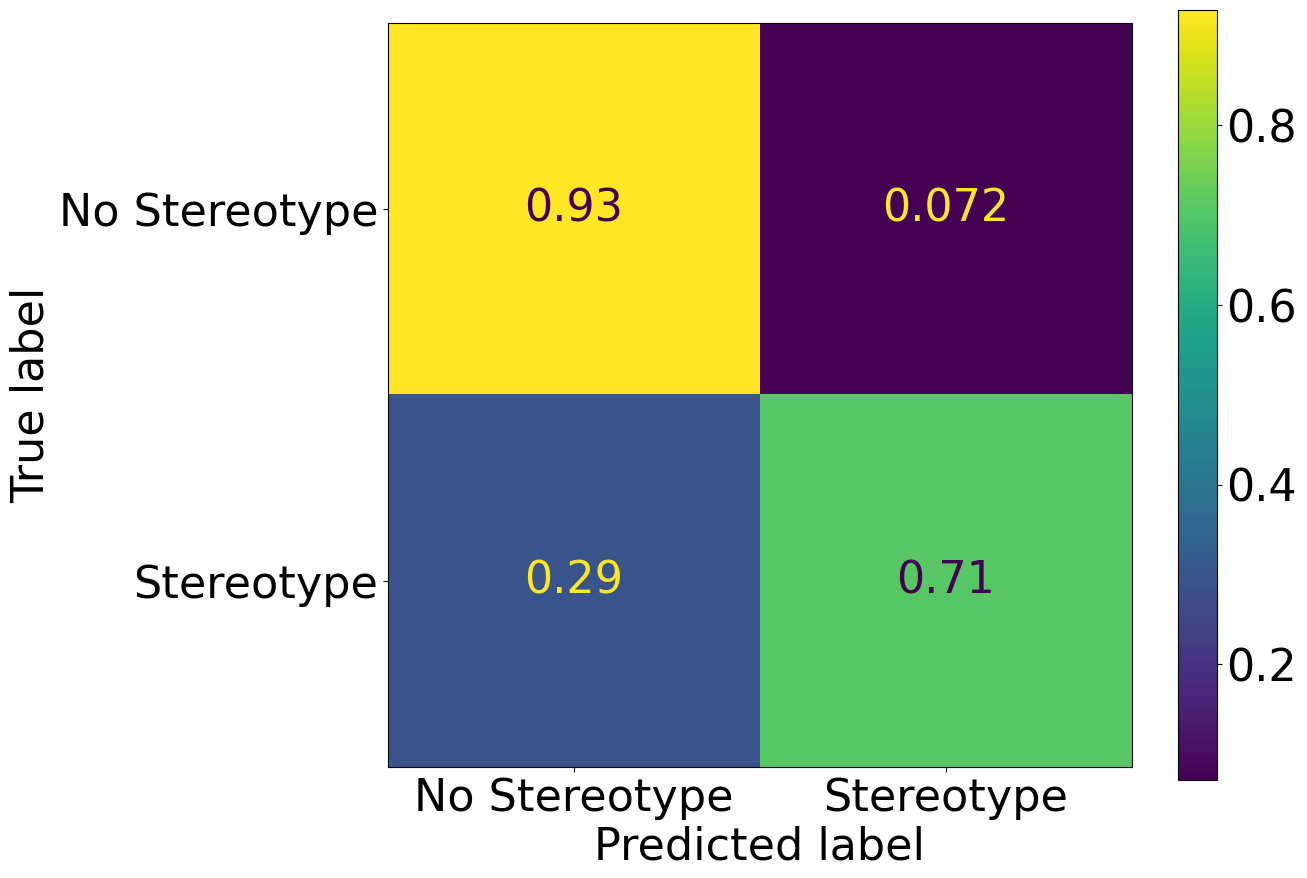

In [18]:
import os
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

# Configuración de gráficos
plt.rcParams.update({'font.size': 32})
plt.rcParams['figure.figsize'] = 12, 10

def gather_predictions_and_display_confusion_matrix(base_path, gold_file):
    # Leer el archivo gold standard
    gold_df = pd.read_csv(gold_file)
    
    # Inicializar listas para almacenar todas las predicciones
    all_gold_labels = []
    all_predictions = []

    # Iterar sobre cada carpeta de Fold en el path base
    for fold_dir in os.listdir(base_path):
        fold_path = os.path.join(base_path, fold_dir)
        
        # Verificar que sea un directorio y que el nombre contenga 'Fold'
        if os.path.isdir(fold_path) and 'Fold' in fold_dir:
            # Buscar archivos que terminen en _hard.json
            for file_name in os.listdir(fold_path):
                if file_name.endswith('_hard.json'):
                    file_path = os.path.join(fold_path, file_name)
                    
                    # Leer el archivo de predicciones
                    predictions_df = pd.read_json(file_path, orient='records')
                    
                    # Filtrar las etiquetas doradas según los IDs de las predicciones
                    gold_labels = gold_df[gold_df["id"].isin(predictions_df["id"])]["stereotype"]
                    
                    # Convertir las predicciones en valores binarios (1 para Stereotype, 0 para No Stereotype)
                    predictions = predictions_df["value"].apply(lambda x: 1 if x == "Stereotype" else 0)
                    
                    # Añadir las etiquetas y predicciones a las listas
                    all_gold_labels.extend(gold_labels)
                    all_predictions.extend(predictions)

    # Mostrar la matriz de confusión con todas las predicciones acumuladas
    ConfusionMatrixDisplay.from_predictions(
        all_gold_labels,
        all_predictions,
        normalize='true',
        cmap='viridis',
        display_labels=["No Stereotype", "Stereotype"]
    )
    plt.show()

# Ejemplo de uso
base_path = "/home/elural/DETESTS-DIS/scripts/logs/stereotype/hard/HardLabelEps0951e-5"
gold_file = "train.csv"
gather_predictions_and_display_confusion_matrix(base_path, gold_file)


In [94]:
def calcular_h(series, confianza=0.95):
    n = len(series)
    se = series.sem()
    h = se * stats.t.ppf((1 + confianza) / 2., n - 1)
    return h

def obtener_metricas_con_intervalo_confianza(lista_archivos_csv):
    lista_mejores_resultados = []
    lista_promedios = []

    for archivo_csv in lista_archivos_csv:
        df = pd.read_csv(archivo_csv)
        
        # Encontrar el índice de la fila con el menor dev_loss para cada fold
        idx_min_dev_loss = df.groupby('Fold')['dev_loss'].idxmin()
        
        # Obtener las filas con el menor dev_loss para cada fold y seleccionar las métricas deseadas
        mejores_resultados = df.loc[idx_min_dev_loss, ['f1_1', 'precision_1', 'recall_1', 'ce']]
        lista_mejores_resultados.append(mejores_resultados)
        
        # Calcular promedios y sus h
        f1_h = calcular_h(df['f1_1'])
        precision_h = calcular_h(df['precision_1'])
        recall_h = calcular_h(df['recall_1'])
        
        promedios_con_h = {
            'f1_1': df['f1_1'].mean(),
            'precision_1': df['precision_1'].mean(),
            'recall_1': df['recall_1'].mean(),
            'ce': df['ce'].mean(),
            'f1_h': f1_h,
            'precision_h': precision_h,
            'recall_h': recall_h
        }
        
        lista_promedios.append(promedios_con_h)

    # Concatenar todos los DataFrames de mejores resultados
    resultados_consolidados = pd.concat(lista_mejores_resultados, ignore_index=True)
    
    # Crear un DataFrame para los promedios con h
    df_promedios = pd.DataFrame(lista_promedios)
    
    return resultados_consolidados, df_promedios

# Ejemplo de uso

all_metrics_means = []
hard_labels = ['/home/eliasurios/Documentos/DETESTS-DIS/scripts/task1/HardLabelStereotypeLr1e-5Eps97.csv', '/home/eliasurios/Documentos/DETESTS-DIS/scripts/task1/HardLabelStereotype1e-5Eps97Context.csv', '/home/eliasurios/Documentos/DETESTS-DIS/scripts/task1/HardLabelStereotype1e-5Eps97ContextAug.csv']
hard_labels_metrics, hard_labels_metrics_with_ic = obtener_metricas_con_intervalo_confianza(hard_labels)
soft_labels = ['/home/eliasurios/Documentos/DETESTS-DIS/scripts/task1/SoftLabelStereotype2e-5Eps90.csv', '/home/eliasurios/Documentos/DETESTS-DIS/scripts/task1/SoftLabelStereotype2e-5Eps90Context.csv', '/home/eliasurios/Documentos/DETESTS-DIS/scripts/task1/SoftLabelStereotype2e-5Eps90ContextAug.csv']
soft_labels_metrics, soft_labels_metrics_with_ic = obtener_metricas_con_intervalo_confianza(soft_labels)
multi_task_labels = ['/home/eliasurios/Documentos/DETESTS-DIS/scripts/task1/MultiTaskStereotype2e-5Eps95.csv', '/home/eliasurios/Documentos/DETESTS-DIS/scripts/task1/MultiTaskStereotype2e-5Eps95Context.csv', '/home/eliasurios/Documentos/DETESTS-DIS/scripts/task1/MultiTaskStereotype2e-5Eps95ContextAug.csv']
multi_task_metrics, multi_task_metrics_with_ic = obtener_metricas_con_intervalo_confianza(multi_task_labels)

all_metrics_means = hard_labels_metrics_with_ic["ce"].values.tolist() +  soft_labels_metrics_with_ic["ce"].values.tolist() +   multi_task_metrics_with_ic["ce"].values.tolist()
all_metrics_means

[0.4824314153194427,
 0.4739852154254913,
 0.46505556523799896,
 0.3885061585903168,
 0.38148963153362275,
 0.3628871691226959,
 0.5055040341615676,
 0.4973158401250839,
 0.4528349697589874]

/tmp/ipykernel_147535/4101157913.py:37: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(


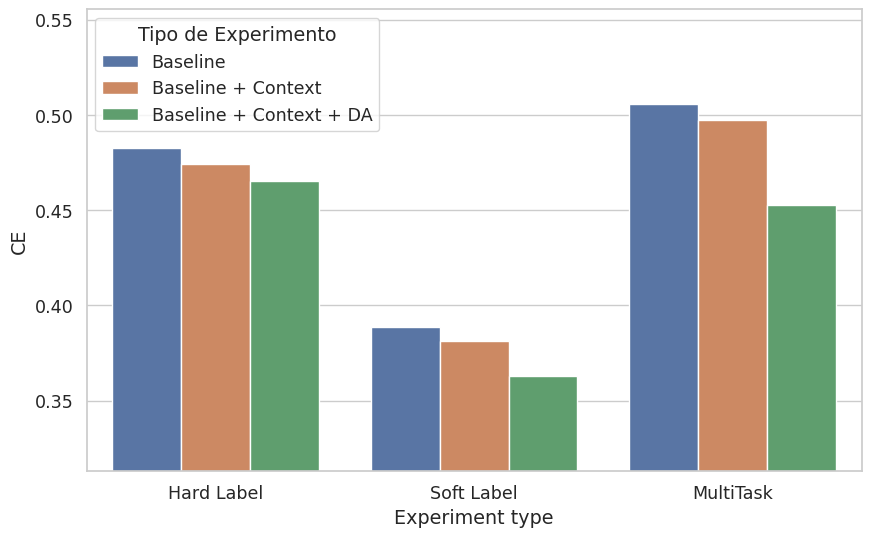

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def graficar_resultados(resultados, errores=None, labels_experimentos=None, labels_leyenda=None, nombres_tandas=None, intervalo_confianza=95):
    """
    Crea una gráfica de barras agrupadas con colores diferenciados por tanda y añade una leyenda usando seaborn.
    
    :param resultados: Lista de resultados (F1 Scores) para cada experimento.
    :param errores: Lista de errores para cada experimento (opcional). Si es None, no se añade error a la gráfica.
    :param labels_experimentos: Lista de etiquetas para cada tipo de experimento.
    :param labels_leyenda: Lista de etiquetas para la leyenda.
    :param nombres_tandas: Lista de nombres para cada tanda (opcional). Si es None, se usan nombres genéricos.
    :param intervalo_confianza: Nivel de intervalo de confianza en porcentaje.
    """
    # Número de experimentos por tanda y número de tandas
    num_experimentos_por_tanda = len(labels_experimentos)
    num_tandas = len(resultados) // num_experimentos_por_tanda

    # Crear un DataFrame para seaborn
    df = pd.DataFrame({
        'Tanda': np.repeat(nombres_tandas or [f'Tanda {i + 1}' for i in range(num_tandas)], num_experimentos_por_tanda),
        'Experimento': labels_experimentos * num_tandas,
        'F1 Score': resultados,
        'Error': errores if errores else [np.nan] * len(resultados)
    })

    # Usar la paleta 'deep' de seaborn para obtener colores
    colores_experimentos = sns.color_palette("deep")[:num_experimentos_por_tanda]
    sns.set(font_scale=1.15)
    sns.set_style("whitegrid")
    # Crear la figura y el eje
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Graficar las barras con seaborn
    sns.barplot(
        x='Tanda', 
        y='F1 Score', 
        hue='Experimento', 
        data=df,
        palette=colores_experimentos,
        ci=intervalo_confianza,
        ax=ax
    )

    # Añadir la leyenda
    if labels_leyenda:
        handles, _ = ax.get_legend_handles_labels()
        ax.legend(handles, labels_leyenda, title='Tipo de Experimento')

    # Etiquetas y título
    ax.set_xlabel('Experiment type')
    ax.set_ylabel('CE')
    ax.set_title('')

    # Ajustar el rango del eje Y
    ax.set_ylim(min(resultados) - 0.05, max(resultados) + 0.05)

    # Mostrar la gráfica
    plt.show()

# Ejemplo de uso
resultados_f1 = [0.7, 0.75, 0.72, 0.65, 0.68, 0.66, 0.80, 0.82, 0.79]
errores_f1 = [0.05, 0.04, 0.03, 0.06, 0.05, 0.04, 0.02, 0.03, 0.01]
labels_experimentos = ['Baseline', 'Baseline + Context', 'Baseline + Context + DA']
labels_leyenda = ['Baseline', 'Baseline + Context', 'Baseline + Context + DA']
nombres_tandas = ['Hard Label', 'Soft Label', 'MultiTask']

graficar_resultados(all_metrics_means, errores_f1, labels_experimentos, labels_leyenda, nombres_tandas, intervalo_confianza=95)
